<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/FVC_TFREC_read_write.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [9]:
!pip install jsonlines

#Import Libs

In [10]:
import os, math
import numpy as np
import pandas as pd
import requests
import shutil
from pathlib import Path
import jsonlines
from urllib.parse import urlparse, parse_qs
import json
import ast
import re

from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

Tensorflow version 2.5.0


#Configurations

In [51]:
data_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/FVC_clickbait.csv'

tfrec_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data'
tfrec_output_path = os.path.join(tfrec_root,'FVC_image_text')

In [47]:
CLASSES = [b'nonclickbaits', b'clickbaits'] 
SHARDS = 16
TARGET_SIZE = [180, 180]

#Scripts

In [ ]:
#@title "Utilities [RUN ME]"
def parse_function(image_path, text, label):
    image_string = tf.io.read_file(image_path)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    return image, text, label

def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(CLASSES[label.numpy()], fontsize=16)
    subplot += 1
    if i==8:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [29]:
#@title "Utilities [RUN ME]"
def resize_and_crop_image(image, text, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, text, label
  

In [34]:
#@title "Utilities[Run Me]"
def recompress_image(image,text, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, text, label, height, width

In [45]:
#@title "Utilities[Run Me]"
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, text, label, height, width):  
  class_num = label 

  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list
      "text":  _bytestring_feature([text]),       # text feature   
      "label":         _bytestring_feature([CLASSES[label]]),          # fixed length (1) list of strings, the text label
      "image_size":          _int_feature([height, width]),         # fixed length (2) list of ints
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  


In [53]:
#@title "Utilities[Run Me]"
def WriteAsTFRecord(dataset, tfrec_root_path, tfrec_output_path):
  print("Writing TFRecords")

  if not os.path.exists(tfrec_root_path):
    os.mkdir(tfrec_root_path)

  for shard, (image, text, label, height, width) in enumerate(dataset):
    # batch size used as shard size here
    shard_size = image.numpy().shape[0]
    # good practice to have the number of records in the filename
    filename = tfrec_output_path + "{:02d}-{}.tfrec".format(shard, shard_size)
  
    with tf.io.TFRecordWriter(filename) as out_file:
      for i in range(shard_size):
        example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            text.numpy()[i],
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
        out_file.write(example.SerializeToString())
      print("Wrote file {} containing {} records".format(filename, shard_size))

In [60]:
#@title "Utilities[Run Me]"
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "image_size":          tf.io.FixedLenFeature([2], tf.int64)  # two integers
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    height = example['image_size'][0]
    width  = example['image_size'][1]
    return image, text, class_num, label, height, width


#Load Data

In [11]:
FVC_df = pd.read_csv(data_path)
FVC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1589 entries, 0 to 1588
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is_clickbait            1589 non-null   int64 
 1   thumbnail_320_180_path  1589 non-null   object
 2   text                    1589 non-null   object
dtypes: int64(1), object(2)
memory usage: 37.4+ KB


#Save dataframe as TFREC 

##Create tensorflow dataset from csv file

In [13]:
FVC_df.shape, FVC_df.columns

((1589, 3),
 Index(['is_clickbait', 'thumbnail_320_180_path', 'text'], dtype='object'))

In [15]:
Y = FVC_df.pop('is_clickbait')
X_IMAGE = FVC_df['thumbnail_320_180_path']
X_TEXT = FVC_df['text']

In [16]:
Y = np.array(Y)
X_IMAGE = np.array(X_IMAGE)
X_TEXT = np.array(X_TEXT)
Y.shape, X_IMAGE.shape, X_TEXT.shape

((1589,), (1589,), (1589,))

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((X_IMAGE, X_TEXT, Y)).map(parse_function, num_parallel_calls=AUTO)

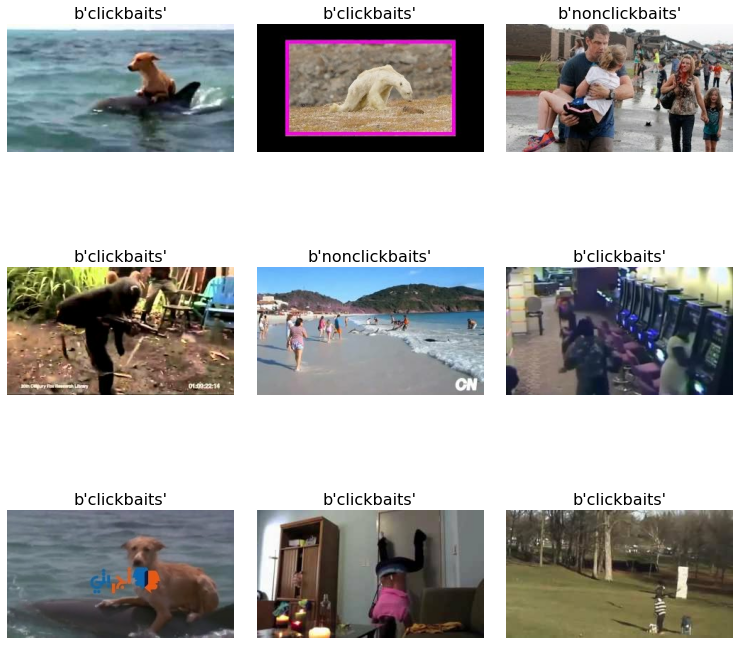

In [20]:
display_image_dataset = dataset.map(lambda image,text, class_num: (image, class_num))
display_9_images_from_dataset(display_image_dataset)

In [32]:
display_text_dataset = dataset.map(lambda image,text, class_num: (text, class_num))

for i, (text, label) in enumerate(display_text_dataset.take(9)):
  print(f'text: {text.numpy()} : is_clickbait : {CLASSES[label.numpy()]}')
  
  

text: b'dolphin saving a dog see my latest videos' : is_clickbait : b'clickbaits'
text: b'heart wrenching video shows starving polar bear on iceless land heart wrenching video shows starving polar bear on iceless land heart wrenching video shows starving polar bear on iceless land when photographer paul nicklen and filmmakers from conservation group sea legacy arrived on baffin island in late summer they came acro' : is_clickbait : b'clickbaits'
text: b'oklahoma tornado elementary school moments after tornado struck school pupils in moore oklahoma cry and hug teachers and parents just moments after monday s devastating tornado hit briarwood plaza elementary school strong winds are still blowing as distressed children search for friends and parents the school was one of five in the path of the twister which left at least people dead and injured subscribe to the guardian on youtube support the guardian today in focus podcast sign up for the guardian documentaries newsletter the guardian 

##Resize and crop images to common size

In [31]:
dataset_m1 = dataset.map(resize_and_crop_image, num_parallel_calls=AUTO) 
for image, text, label in dataset_m1.take(10):
  print(image.numpy().shape, CLASSES[label.numpy()])

(180, 180, 3) b'clickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'nonclickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'nonclickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'nonclickbaits'


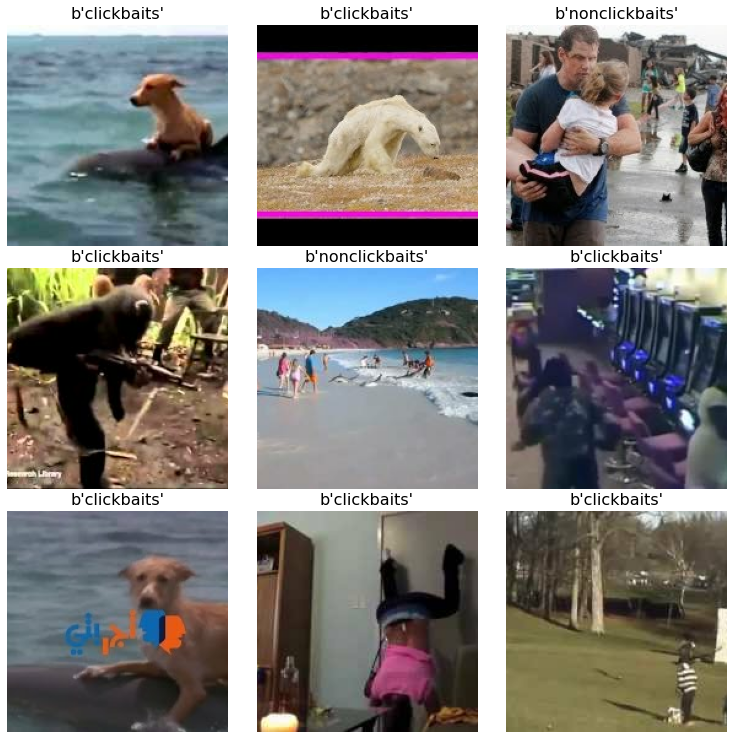

In [33]:
display_image_dataset = dataset_m1.map(lambda image,text, class_num: (image, class_num))
display_9_images_from_dataset(display_image_dataset)

##Recompress the images

In [41]:
dataset_m2 = dataset_m1.map(recompress_image, num_parallel_calls=AUTO)

##Write dataset to TFRecord files

In [54]:
nb_images = len(dataset_m2)
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

Pattern matches 1589 images which will be rewritten as 16 .tfrec files containing 100 images each.


In [55]:
dataset_m3 = dataset_m2.batch(shard_size)

In [56]:
WriteAsTFRecord(dataset_m3, tfrec_root_path, tfrec_output_path)

Writing TFRecords
Wrote file /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/FVC_image_text00-100.tfrec containing 100 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/FVC_image_text01-100.tfrec containing 100 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/FVC_image_text02-100.tfrec containing 100 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/FVC_image_text03-100.tfrec containing 100 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/FVC_image_text04-100.tfrec containing 100 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/FVC_image_text05-100.tfrec containing 100 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_

#Create TF Dataset from TFRecord file

In [58]:
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(tfrec_output_path + "*.tfrec")
len(filenames)

16

In [67]:
dataset_m4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset_m4 = dataset_m4.with_options(option_no_order)
dataset_m4 = dataset_m4.map(read_tfrecord, num_parallel_calls=AUTO)
# For true randomness, we set the shuffle buffer to the full dataset size.
dataset_m4 = dataset_m4.shuffle(nb_images)

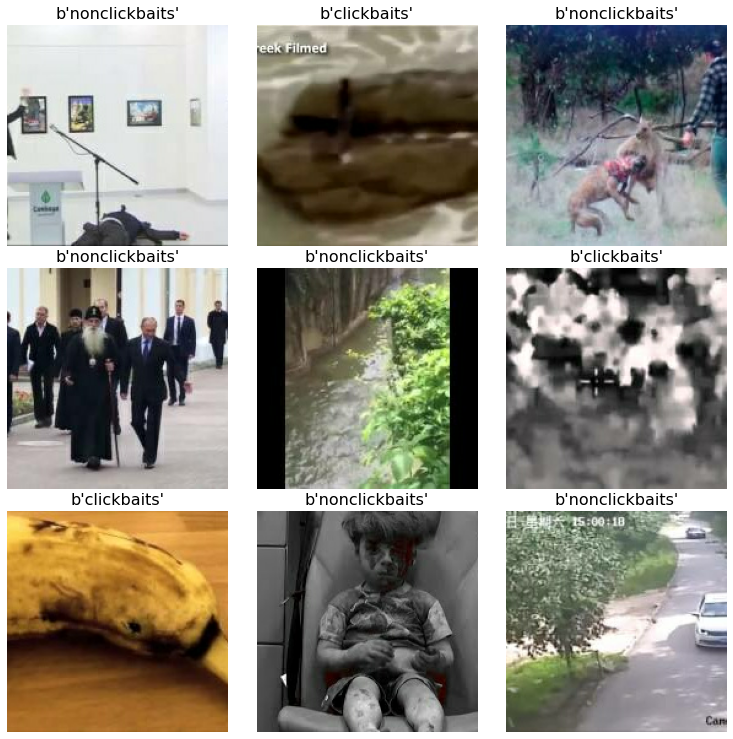

In [68]:
display_dataset = dataset_m4.map(lambda image,text, class_num, label, height, width: (image, class_num))
display_9_images_from_dataset(display_dataset)